# Regression with an Insurance Dataset

Your Goal: The objectives of this challenge is to predict insurance premiums based on various factors.

# Preparation

## Load libraries

In [ ]:
# !pip install -U lightautoml[all]

In [ ]:
# from lightautoml.automl.presets.tabular_presets import TabularAutoML
# from lightautoml.tasks import Task
# import torch
# import os

In [1]:
import pandas as pd              # For data manipulation and analysis
import numpy as np               # For numerical computing
from datetime import datetime
import scipy.stats as stats      # For statistical analysis
import math
import matplotlib                # For plotting and visualization
import matplotlib.pyplot as plt  
from pandas.plotting import parallel_coordinates
import seaborn as sns            # For statistical data visualization
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# For machine learning
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool

from lightgbm import early_stopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, make_scorer, mean_squared_error,
                             f1_score, confusion_matrix, classification_report, mean_squared_log_error)
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder, FunctionTransformer, OneHotEncoder
import category_encoders
from category_encoders import TargetEncoder
import optuna

## Load datasets

In [26]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv')

# Exploratory Data Analysis

In [ ]:
df_train.head()

In [ ]:
df_train.info()

## Univariate Analysis

How does each explanatory **numerical feature** and target feature distribute?

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))

ax = sns.histplot(data = df_train,
             x = 'Premium Amount',
             bins = 20,
             kde = True,
             color = '#FFBE98')
ax.set_title('Distribution of Premium Amount ($)')
ax.set_ylabel('')

sns.despine(top = True)

In [ ]:
num_cols = [col for col in df_test.columns if df_test[col].dtypes in ['float']]
cat_cols = [col for col in df_test.columns if df_test[col].dtypes in ['object']]

fig, axes = plt.subplots(4, 2, figsize=(20, 25))
 
for i, column in enumerate(num_cols):
    plt.subplots_adjust(top = 0.85)
    ax = sns.histplot(data = df_train, 
                x = column, 
                bins = 20,
                kde = True,
                ax = axes[i // 2, i % 2])
    ax.set_title('Distribution of ' + column)
    
fig.tight_layout(h_pad = 2)
plt.subplots_adjust(top = 0.93)
plt.suptitle('Distribution of Explanatory Features', fontsize = 20)
plt.show()

In [ ]:
age_bin = [0, 20, 40, 60, 80]
income_bin = [0, 50000, 100000, 150000, 200000]
health_bin = [0, 10, 20, 30, 40, 50, 60]
vehicle_bin = [0, 5, 10, 15, 20]
credit_bin = [0, 200, 400, 600, 800]

# Binning with string labels
df_train['age_bin'] = pd.cut(df_train['Age'], bins=age_bin, labels=[f"{age_bin[i]}-{age_bin[i+1]}" for i in range(len(age_bin) - 1)])
df_train['income_bin'] = pd.cut(df_train['Annual Income'], bins=income_bin, labels=[f"{income_bin[i]}-{income_bin[i+1]}" for i in range(len(income_bin) - 1)])
df_train['health_bin'] = pd.cut(df_train['Health Score'], bins=health_bin, labels=[f"{health_bin[i]}-{health_bin[i+1]}" for i in range(len(health_bin) - 1)])
df_train['vehicle_bin'] = pd.cut(df_train['Vehicle Age'], bins=vehicle_bin, labels=[f"{vehicle_bin[i]}-{vehicle_bin[i+1]}" for i in range(len(vehicle_bin) - 1)])
df_train['credit_bin'] = pd.cut(df_train['Credit Score'], bins=credit_bin, labels=[f"{credit_bin[i]}-{credit_bin[i+1]}" for i in range(len(credit_bin) - 1)])

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(20, 30)) 
axes = axes.flatten()  # Flatten the grid for easy indexing
bin_cols = ['age_bin', 'income_bin', 'health_bin', 'vehicle_bin', 'credit_bin']

for i, column in enumerate(bin_cols):
    # Main chart
    sns.countplot(data=df_train, x=column, color='#FFBE98', ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel(column)
    
    # Secondary axis for average premium
    ax2 = axes[i].twinx()
    avg_premium = df_train.groupby(column)['Premium Amount'].mean()
    ax2.plot(avg_premium.index, avg_premium.values, color='#1873D3', marker='o', label='Avg Premium')
    ax2.set_ylabel('Avg Premium Amount ($)')
    
    # Legends and adjustments
    ax2.legend(loc='upper right')
    sns.despine(top=True, right=False, ax=axes[i])
    sns.despine(top=True, right=False, ax=ax2)

# Remove empty subplots
for j in range(len(bin_cols), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout(h_pad=3)
plt.subplots_adjust(top=0.93)
plt.suptitle('Distribution of Numerical Features and Average Premium Amounts', fontsize=23)
plt.show()

How does each categorical feature distributed?

In [ ]:
cat_cols = ['Gender','Marital Status','Education Level','Occupation','Location','Policy Type','Customer Feedback','Smoking Status','Exercise Frequency','Property Type']

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(20, 30)) 
axes = axes.flatten()  # Flatten the grid for easy indexing

for i, column in enumerate(cat_cols):
    # Main chart
    sns.countplot(data=df_train, x=column, color='#FFBE98', ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel(column)
    
    # Secondary axis for average premium
    ax2 = axes[i].twinx()
    avg_premium = df_train.groupby(column)['Premium Amount'].mean()
    ax2.plot(avg_premium.index, avg_premium.values, color='#1873D3', marker='o', label='Avg Premium')
    ax2.set_ylabel('Avg Premium Amount ($)')
    
    # Legends and adjustments
    ax2.legend(loc='upper right')
    sns.despine(top=True, right=False, ax=axes[i])
    sns.despine(top=True, right=False, ax=ax2)

# Remove empty subplots
for j in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout(h_pad=3)
plt.subplots_adjust(top=0.93)
plt.suptitle('Distribution of Categorical Features and Average Premium Amounts', fontsize=23)
plt.show()

## Multivariate Analysis

In [ ]:
# Correlation Matrix Heatmap
fig, ax = plt.subplots(figsize = (25,15))
df_features = df_train.select_dtypes(include='float')
corr = df_features.corr()
hm = sns.heatmap(corr,
                annot = True,
                ax = ax,
                cmap = sns.color_palette("vlag", as_cmap = True),
                fmt = '.5f')
fig.subplots_adjust(top = 0.95)
plt.suptitle('Predictors Correlation Heatmap', fontsize = 14)
plt.show()

# Statistical Analysis

## One-Way ANOVA or Kruskal-Wallis Test
ANOVA assumptions
Like other types of statistical methods, ANOVA compares the means of different groups and shows you if there are any statistical differences between the means. ANOVA is classified as an omnibus test statistic. This means that it can’t tell you which specific groups were statistically significantly different from each other, only that at least two of the groups were.

ANOVA relies on three main assumptions that must be met for the test results to be valid.
1. Normality
The first assumption is that the groups each fall into what is called a normal distribution. This means that the groups should have a bell-curve distribution with few or no outliers.

2. Homogeneity of variance
Also known as homoscedasticity, this means that the variances between each group are the same.

3. Independence
The final assumption is that each value is independent from each other. This means, for example, that unlike a conjoint analysis the same person shouldn’t be measured multiple times.

ANOVA Hypotheses
- Null hypothesis: Groups means are equal (no variation in means of groups)
H0: $\mu_1 = \mu_2 = ... = \mu_p$

- Alternative hypothesis: At least, one group mean is different from other groups
H1: All $\mu$ are not equal

Hence, before performing One-Way ANOVA Test, we will test if the assumptions are satisfied. If not, we will perform Kruskal-Wallis Test.

In [ ]:
# Importing libraries 
import statsmodels.api as sm 
from statsmodels.formula.api import ols 

In [ ]:
import scipy.stats as stats
from statsmodels.stats.diagnostic import lilliefors

# Function to verify assumptions and perform Kruskal-Wallis test
def check_assumptions_and_test(df, feature, target):
    # Check for normality of target distribution in each group
    groups = df.groupby(feature)[target].apply(list)
    normality_results = {}
    
    for group, values in groups.items():
        # Perform Lilliefors test for normality (Kolmogorov-Smirnov for small data)
        _, p_value = lilliefors(values, dist='norm')
        normality_results[group] = p_value
    
    # Check for homogeneity of variances using Levene's test
    groups_list = [df[df[feature] == g][target] for g in df[feature].unique()]
    _, levene_p = stats.levene(*groups_list, center='mean')
    
    print(f"Normality Test (Lilliefors p-values): {normality_results}")
    print(f"Levene's Test for Homogeneity of Variances (p-value): {levene_p}")
    
    # If assumptions are not satisfied, perform Kruskal-Wallis test
    if any(p < 0.05 for p in normality_results.values()) or levene_p < 0.05:
        print("Assumptions violated. Performing Kruskal-Wallis test.")
        _, kruskal_p = stats.kruskal(*groups_list)
        print(f"Kruskal-Wallis Test p-value: {kruskal_p}")
    else:
        print("Assumptions satisfied. No need for Kruskal-Wallis.")

# Example usage with your dataset
# Replace 'feature' and 'target' with the column names from your dataset
for feature in ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
                'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']:
    print(f"Testing feature: {feature}")
    check_assumptions_and_test(df_train, feature, 'Premium Amount')
    print("\n")

#### Interpretation of Results:
1. Normality Assumption:

- For all features, the Lilliefors test consistently indicates non-normality (p-value < 0.05).
- Normality assumption is violated for every feature.

2. Homogeneity of Variances:

- Levene's test results show mixed outcomes:
    - Some features, like Gender, Location, and Smoking Status, satisfy variance homogeneity (p-value > 0.05).
    - For Property Type, Levene's test indicates variance heterogeneity (p-value < 0.05).
    - For some features (Marital Status, Occupation, Customer Feedback), nan results suggest issues with the test, possibly due to group size or data inconsistencies.

3. Kruskal-Wallis Test:

- Significance: None of the features tested (including Gender, Education Level, Policy Type) showed significant differences in medians across groups (p-value > 0.05 for all).
- For features like Marital Status, Occupation, and Customer Feedback, nan p-values suggest further investigation is needed (e.g., checking for missing data or issues in grouping).


Next Steps:

Since Kruskal-Wallis results are not significant for any feature, consider:
- Feature engineering or transformation (e.g., binning, encoding, interaction terms).

Use other feature selection methods (e.g., mutual information, correlation analysis).

## Cramér's V Test
Measures the association between two nominal variables for each categorical pairs as followed.
1. Compute a contingency table for each pair of categorical columns.
2. Use the chi-squared test to calculate the chi-squared statistic.
3. Apply Cramér's V formula

In [ ]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    """Calculate Cramér's V between two categorical variables."""
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    r, k = contingency_table.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# List of categorical columns
categorical_cols = ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location','Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']

# Create an empty DataFrame to store results
results = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

# Calculate Cramér's V for each pair of categorical columns
for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 == col2:
            results.loc[col1, col2] = 1.0  # Perfect correlation with itself
        else:
            results.loc[col1, col2] = cramers_v(df_train[col1], df_train[col2])

# Convert results to numeric for better display
results = results.astype(float)

# Display the correlation matrix
print(results)

#### Interpretation of Results:
- All Cramér’s V values are very close to zero, indicating weak associations between the categorical variables in your dataset.
- Most of the correlations are near zero, suggesting that the features are largely independent of each other in terms of their categorical distribution.

Next Steps for Feature Engineering:
- Explore interactions: While individual features show weak correlation, combinations of features (e.g., gender with marital status) may offer more insightful patterns. Consider adding interaction terms.

# Train-Test Split

In [27]:
X = df_train.drop(columns = ['Premium Amount', 'id'], axis = 1)
y = df_train['Premium Amount']
y_log = np.log1p(y)

In [28]:
# Split the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Engineering

In [29]:
def extract_date_components(df, date_column):
    # Convert the column to datetime type
    df[date_column] = pd.to_datetime(df[date_column])
    # Extract Year, Month, and Day
    df['Year'] = df[date_column].dt.year
    df['Month'] = df[date_column].dt.month
    df['Day'] = df[date_column].dt.day
    # Drop the original column
    df.drop(columns=[date_column], inplace=True)
    return df

def log_transform(df):
    df['Log Annual Income'] = np.log(df['Annual Income']+1)
    # Drop the original column
    df.drop(columns=['Annual Income'], inplace=True)
    return df

for df in [X_train, X_valid, df_test]:
    extract_date_components(df, 'Policy Start Date')
    log_transform(df)

In [ ]:
# def stat_features(df):
#     # Numerical Data
#     df['income_per_dependents'] = df['Annual Income'] * df['Number of Dependents']
#     df['income_age'] = df['Annual Income'] / df['Age']
#     df['vehical_insurance'] = df['Vehicle Age'] - df['Insurance Duration']
#     df['health_credit'] = df['Health Score'] + df['Credit Score']
#     df['claim_credit'] = df['Previous Claims'] * df['Credit Score']
#     df['claim_income'] = df['Previous Claims'] * df['Annual Income']
#     df['health_income'] = df['Health Score'] + df['Annual Income']
#     df['credit_income'] = df['Credit Score'] + df['Annual Income']
#     # Categorical Data
#     # df['gender_education'] = df['Education Level'] + df['Gender']
#     # df['policy_marital'] = df['Policy Type'] + df['Marital Status']
#     # df['exercise_marital'] = df['Exercise Frequency'] + df['Marital Status']
#     # df['location_property'] = df['Location'] + df['Property Type']
#     # df['smoke_location'] = df['Smoking Status'] + df['Location']
#     # df['smoke_exercise'] = df['Exercise Frequency'] + df['Smoking Status']
#     return df

# X_train = stat_features(X_train)
# X_valid = stat_features(X_valid)
# df_train = stat_features(df_train)
# df_test = stat_features(df_test)

# Preprocessing

In [30]:
num_cols = [col for col in df_test.columns if df_test[col].dtypes in ['float', 'int32']]
print('Numerical Features \n', num_cols)
cat_cols = [col for col in df_test.columns if df_test[col].dtypes in ['object']]
print('Categorical Features \n', cat_cols)

Numerical Features 
 ['Age', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration', 'Year', 'Month', 'Day', 'Log Annual Income']
Categorical Features 
 ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']


In [31]:
# Define preprocessing pipelines
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('convert_to_float32', FunctionTransformer(lambda x: x.astype(np.float32)))
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder())
])

# Combine the numerical and categorical pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, num_cols),
        ('cat', categorical_pipeline, cat_cols)
    ]
)

preprocessor.set_output(transform="pandas")

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler()),
                                                 ('convert_to_float32',
                                                  FunctionTransformer(func=<function <lambda> at 0x7fdf6b77f010>))]),
                                 ['Age', 'Number of Dependents', 'Health Score',
                                  'Previous Claims', 'Vehicle Age',
                                  'Credit Score', 'Insurance Duration', 'Year',
                                  'Month', 'Day', 'Log Annual Income']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 ['Gender', 'Marital Status', 'Education Level',
                                  'Occupation', 'Location', 'Policy Type',
                                  'Customer Feedback', 'Smoking Status',
                                  'Exercise Frequency', 'Property Type'])])

In [32]:
# Apply the transformations to the training and validation sets
X_train_processed = preprocessor.fit_transform(X_train)
X_valid_processed = preprocessor.transform(X_valid)

# Machine Learning

## Define Metrics

In [65]:
def rmsle(y_true, y_pred):
    y_pred = np.maximum(y_pred, 20)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

RMSLE = make_scorer(rmsle, greater_is_better=False)

In [34]:
def cross_val_score_log(model, X, y, n_splits=5, random_state=42):
    
    """"
    Perform cross-validation and return scores using log-transformed y.
    """

    kf = KFold(n_splits = 5, shuffle=True, random_state=random_state)
    scores = []

    for train_index, test_index in kf.split(X):
        X_train_split, X_valid_split = X.iloc[train_idx], X.iloc[val_idx]
        y_train_split, y_valid_split = y_log.iloc[train_idx], y_log.iloc[val_idx]
        
        model.fit(X_train_split, y_train_split)
        preds = model.predict(X_valid_split)
        
        # Calculate the score directly in the logarithmic scale
        score = np.sqrt(mean_squared_error(y_valid_split, preds))
        scores.append(score)

    mean_score = np.mean(scores)
    return mean_score

## Feature Selection

In [35]:
# Initialize the model
model = XGBRegressor(random_state=42, 
                     tree_method = 'hist', 
                     device = 'cuda', 
                     n_jobs = -1)

# Calculate the CV score with all features
cv_score = -cross_val_score(model, X_train_processed, y_train, cv=5, scoring = RMSLE).mean()
print(f'CV score with all features: {cv_score}')

# Store the results in a list
results = []

# Loop through each feature and calculate the CV score without that feature
for feature in X_train_processed.columns:
    X_temp = X_train_processed.drop(feature, axis=1)
    cv_score_temp = -cross_val_score(model, X_temp, y_train, cv=5, scoring = RMSLE).mean()
    print(f'CV score without {feature}: {cv_score_temp}')
    results.append((feature, cv_score_temp))

# Sort the results in ascending order of CV scores
results.sort(key=lambda x: x[1])

# Store features whose removal results in a lower CV score
lower_cv_features = [feature for feature, score in results if score < cv_score]

# Print the sorted results and the features with lower CV scores
print("")
print("Features whose removal results in a lower CV score:")
print("")
for feature, score in results:
    if score < cv_score:
        print(f'- {feature}')

CV score with all features: 1.1355236887806683
CV score without num__Age: 1.1354005112273853
CV score without num__Number of Dependents: 1.1360582956575134
CV score without num__Health Score: 1.1464596433271144
CV score without num__Previous Claims: 1.1517624881365385
CV score without num__Vehicle Age: 1.1356085961084554
CV score without num__Credit Score: 1.1608319522488748
CV score without num__Insurance Duration: 1.135648465361024
CV score without num__Year: 1.1400632749102648
CV score without num__Month: 1.135886127353621
CV score without num__Day: 1.1356814955581038
CV score without num__Log Annual Income: 1.166602722215467
CV score without cat__Gender: 1.1361602987041999
CV score without cat__Marital Status: 1.1374945008045196
CV score without cat__Education Level: 1.1360647069400402
CV score without cat__Occupation: 1.1359410903559566
CV score without cat__Location: 1.135484308721442
CV score without cat__Policy Type: 1.1355053112381808
CV score without cat__Customer Feedback: 1

In [36]:
X_train_selected = X_train_processed.drop(columns = lower_cv_features)
X_valid_selected = X_valid_processed.drop(columns = lower_cv_features)

## Define Models
### XGBoost

In [44]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True,random_state=42)

# Initialize model
xgb_params_1 = {
    'max_depth': 7, 
    'learning_rate': 0.048600089743471644, 
    'min_child_weight': 1.1685927782882253, 
    'colsample_bytree': 0.5288242720975447, 
    'reg_alpha': 8.062968886652984, 
    'reg_lambda': 0.09005692004244192, 
    'subsample': 0.9618549980615656, 
    'n_estimators': 476,
    'objective': 'reg:squaredlogerror',
    'booster': 'gbtree',
    'eval_metric': 'rmse',
    'random_state': 0
}

xgb_1 = XGBRegressor(**xgb_params_1)
scores = []

# Loop through each fold
for i, (train_idx, val_idx) in enumerate(kf.split(X_train_selected)):
    print(f"------------ Working on Fold {i} ------------")
    
    X_train_split, X_valid_split = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
    y_train_split, y_valid_split = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Fit model
    xgb_1.fit(X_train_split,y_train_split,
              eval_set=[(X_valid_split, y_valid_split)],
              early_stopping_rounds=50,
              verbose=False)
    y_pred_xgb = xgb_1.predict(X_valid_split)
    score = rmsle(y_valid_split, y_pred_xgb)
    print(f"The oof RMSLE score is {score}")
    scores.append(score)

xgb_oof_score = np.mean(scores)  
xgb_std = np.std(scores)
print(f"The 5-fold average oof RMSLE score of the XGB model is {xgb_oof_score}")
print(f"The 5-fold std oof RMSLE score of the XGB model is {xgb_std}") 

------------ Working on Fold 0 ------------
The oof RMSLE score is 1.094564452244737
------------ Working on Fold 1 ------------
The oof RMSLE score is 1.0923098022165
------------ Working on Fold 2 ------------
The oof RMSLE score is 1.091985479032213
------------ Working on Fold 3 ------------
The oof RMSLE score is 1.0937423638915142
------------ Working on Fold 4 ------------
The oof RMSLE score is 1.0919978335034104
The 5-fold average oof RMSLE score of the XGB model is 1.092919986177675
The 5-fold std oof RMSLE score of the XGB model is 0.0010465722503474014


[0.         0.         0.         0.         0.04416307 0.
 0.         0.         0.         0.95583695 0.         0.
 0.         0.         0.         0.         0.        ]


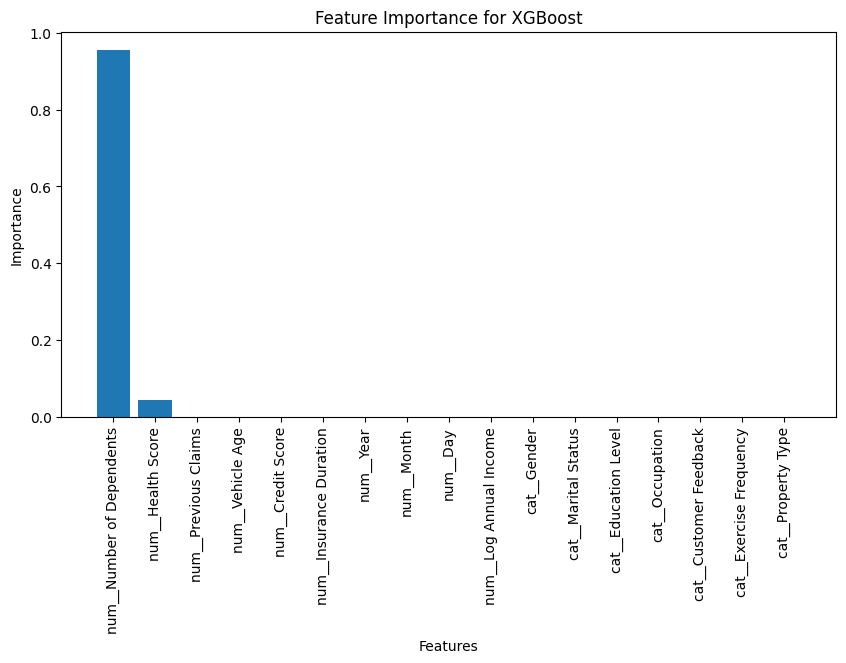

In [45]:
feature_importances = xgb_1.feature_importances_
print(feature_importances)
# Sort feature importances and corresponding feature names
sorted_indices = feature_importances.argsort()[::-1]
sorted_features = X_train_selected.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]
plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_features)
plt.title(f"Feature Importance for XGBoost")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(range(len(X_train_selected.columns)), X_train_selected.columns, rotation=90)
plt.show()

------------ Working on Fold 0 ------------
The oof RMSLE score is 1.097467918201854
------------ Working on Fold 1 ------------
The oof RMSLE score is 1.0952115479745568
------------ Working on Fold 2 ------------
The oof RMSLE score is 1.0949303473539933
------------ Working on Fold 3 ------------
The oof RMSLE score is 1.0966358433182515
------------ Working on Fold 4 ------------
The oof RMSLE score is 1.0948808464086088
The 5-fold average oof RMSLE score of the XGB model is 1.095825300651453
The 5-fold std oof RMSLE score of the XGB model is 0.0010416140745443136
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


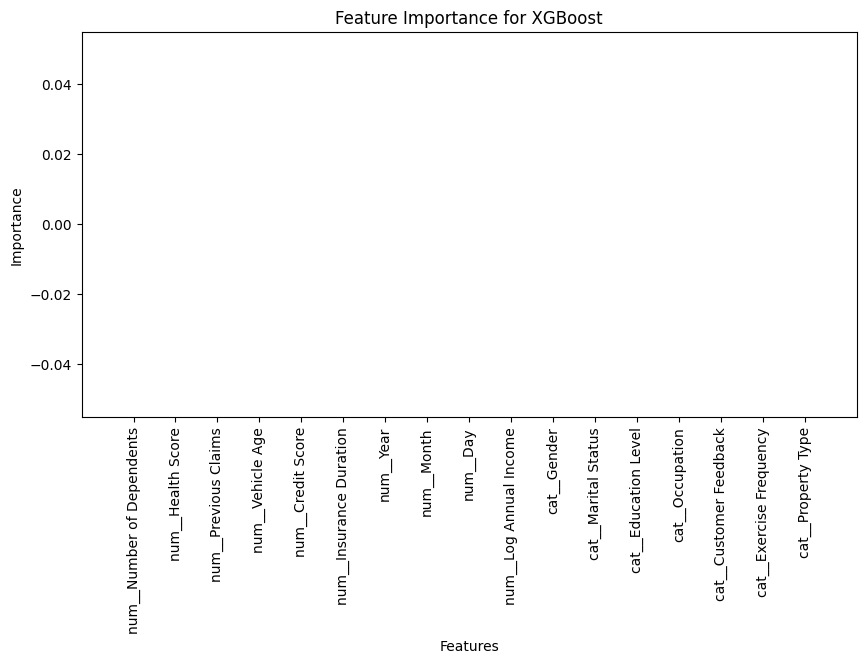

In [46]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True,random_state=42)

# Initialize model
xgb_params_2 = {
        'max_depth': 16, 
        'learning_rate': 0.06727751958634316, 
        'min_child_weight': 1.0408910314363977, 
        'colsample_bytree': 0.7262863552374103, 
        'reg_alpha': 3.731490078787427, 
        'reg_lambda': 9.998531024912493, 
        'subsample': 0.6427242018265176, 
        'n_estimators': 689,
        'objective': 'reg:squaredlogerror',
        'booster': 'gbtree',
        'eval_metric': 'rmse',
        'random_state': 0
}

xgb_2 = XGBRegressor(**xgb_params_2)
scores = []

# Loop through each fold
for i, (train_idx, val_idx) in enumerate(kf.split(X_train_selected)):
    print(f"------------ Working on Fold {i} ------------")
    
    X_train_split, X_valid_split = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
    y_train_split, y_valid_split = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Fit model
    xgb_2.fit(X_train_split,y_train_split,
              eval_set=[(X_valid_split, y_valid_split)],
              early_stopping_rounds=50,
              verbose=False)
    y_pred_xgb = xgb_2.predict(X_valid_split)
    score = rmsle(y_valid_split, y_pred_xgb)
    print(f"The oof RMSLE score is {score}")
    scores.append(score)

xgb_oof_score = np.mean(scores)  
xgb_std = np.std(scores)
print(f"The 5-fold average oof RMSLE score of the XGB model is {xgb_oof_score}")
print(f"The 5-fold std oof RMSLE score of the XGB model is {xgb_std}") 

feature_importances = xgb_2.feature_importances_
print(feature_importances)
# Sort feature importances and corresponding feature names
sorted_indices = feature_importances.argsort()[::-1]
sorted_features = X_train_selected.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]
plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_features)
plt.title(f"Feature Importance for XGBoost")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(range(len(X_train_selected.columns)), X_train_selected.columns, rotation=90)
plt.show()

In [66]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True)

# Initialize model
xgb_params_3 = {
        'booster': 'gbtree',
        'max_depth': 10, 
        'min_child_weight': 19,
        'subsample': 0.8882395046974123,
        'reg_alpha': 0.12361226000167053,
        'reg_lambda': 0.7568174249367466,
        'colsample_bytree': 0.83845902004046,
        'objective': 'reg:squarederror',
        'n_jobs': -1,
        'learning_rate': 0.01,
        'tree_method': 'hist',
        'n_estimators': 3000,
        'enable_categorical': True
}

xgb_3 = XGBRegressor(**xgb_params_3)
scores = []

# Loop through each fold
for i, (train_idx, val_idx) in enumerate(kf.split(X_train_selected)):
    print(f"------------ Working on Fold {i} ------------")
    
    X_train_split, X_valid_split = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
    y_train_split, y_valid_split = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Fit model
    xgb_3.fit(X_train_split,y_train_split,
              eval_set=[(X_valid_split, y_valid_split)],
              early_stopping_rounds=50,
              verbose=False)
    y_pred_xgb = xgb_3.predict(X_valid_split)
    score = rmsle(y_valid_split, y_pred_xgb)
    print(f"The oof RMSLE score is {score}")
    scores.append(score)

xgb_oof_score = np.mean(scores)  
xgb_std = np.std(scores)
print(f"The 5-fold average oof RMSLE score of the XGB model is {xgb_oof_score}")
print(f"The 5-fold std oof RMSLE score of the XGB model is {xgb_std}") 

------------ Working on Fold 0 ------------
The oof RMSLE score is 1.1361922897247558
------------ Working on Fold 1 ------------
The oof RMSLE score is 1.128712355707269
------------ Working on Fold 2 ------------
The oof RMSLE score is 1.1361417997400418
------------ Working on Fold 3 ------------
The oof RMSLE score is 1.1277496492348729
------------ Working on Fold 4 ------------
The oof RMSLE score is 1.1387535962309825
The 5-fold average oof RMSLE score of the XGB model is 1.1335099381275842
The 5-fold std oof RMSLE score of the XGB model is 0.004423016643661284


In [67]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True,random_state=42)

# Initialize model
xgb_params_4 = {
        'booster': 'gbtree',
        'max_depth': 10,
        'min_child_weight': 11,
        'subsample': 0.8709310286076404, 
        'reg_alpha': 0.2429313136646974,
        'reg_lambda': 0.9443233420006127,
        'colsample_bytree': 0.8004450303825076,
        'random_state': 42, 
        'objective': 'reg:squarederror', 
        'n_jobs': -1,
        'learning_rate': 0.01,
        'tree_method': 'hist',
        'n_estimators': 3000,
        'random_state': 42,
        'enable_categorical': True,
        'verbosity': 0,
        'eval_metric': 'rmse',
        'device': "cuda"
}

xgb_4 = XGBRegressor(**xgb_params_4)
scores = []

# Loop through each fold
for i, (train_idx, val_idx) in enumerate(kf.split(X_train_selected)):
    print(f"------------ Working on Fold {i} ------------")
    
    X_train_split, X_valid_split = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
    y_train_split, y_valid_split = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Fit model
    xgb_4.fit(X_train_split,y_train_split,
              eval_set=[(X_valid_split, y_valid_split)],
              early_stopping_rounds=50,
              verbose=False)
    y_pred_xgb = xgb_4.predict(X_valid_split)
    score = rmsle(y_valid_split, y_pred_xgb)
    print(f"The oof RMSLE score is {score}")
    scores.append(score)

xgb_oof_score = np.mean(scores)  
xgb_std = np.std(scores)
print(f"The 5-fold average oof RMSLE score of the XGB model is {xgb_oof_score}")
print(f"The 5-fold std oof RMSLE score of the XGB model is {xgb_std}") 

------------ Working on Fold 0 ------------
The oof RMSLE score is 1.136151443711758
------------ Working on Fold 1 ------------
The oof RMSLE score is 1.1326398553560362
------------ Working on Fold 2 ------------
The oof RMSLE score is 1.1333194480038553
------------ Working on Fold 3 ------------
The oof RMSLE score is 1.1351737630612226
------------ Working on Fold 4 ------------
The oof RMSLE score is 1.1319700485993074
The 5-fold average oof RMSLE score of the XGB model is 1.133850911746436
The 5-fold std oof RMSLE score of the XGB model is 0.0015702955386253457


In [68]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True,random_state=42)

# Initialize model
xgb_params_5 = {
        'booster': 'gbtree', 
        'max_depth': 9,
        'min_child_weight': 13,
        'subsample': 0.8950190330733485, 
        'reg_alpha': 0.3530275785494063,
        'reg_lambda': 0.9564526039891854, 
        'colsample_bytree': 0.8488129245455193,
        'random_state': 42,
        'objective': 'reg:squarederror',
        'n_jobs': -1,
        'learning_rate': 0.01,
        'tree_method': 'hist',
        'n_estimators': 3000,
        'objective': 'reg:squarederror',
        'random_state': 42,
        'enable_categorical': True,
        'verbosity': 0,
        'eval_metric': 'rmse'
}

xgb_5 = XGBRegressor(**xgb_params_5)
scores = []

# Loop through each fold
for i, (train_idx, val_idx) in enumerate(kf.split(X_train_selected)):
    print(f"------------ Working on Fold {i} ------------")
    
    X_train_split, X_valid_split = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
    y_train_split, y_valid_split = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Fit model
    xgb_5.fit(X_train_split,y_train_split,
              eval_set=[(X_valid_split, y_valid_split)],
              early_stopping_rounds=50,
              verbose=False)
    y_pred_xgb = xgb_5.predict(X_valid_split)
    score = rmsle(y_valid_split, y_pred_xgb)
    print(f"The oof RMSLE score is {score}")
    scores.append(score)

xgb_oof_score = np.mean(scores)  
xgb_std = np.std(scores)
print(f"The 5-fold average oof RMSLE score of the XGB model is {xgb_oof_score}")
print(f"The 5-fold std oof RMSLE score of the XGB model is {xgb_std}") 

------------ Working on Fold 0 ------------
The oof RMSLE score is 1.1362518120520229
------------ Working on Fold 1 ------------
The oof RMSLE score is 1.1326798630059582
------------ Working on Fold 2 ------------
The oof RMSLE score is 1.133582670768337
------------ Working on Fold 3 ------------
The oof RMSLE score is 1.1352908509998745
------------ Working on Fold 4 ------------
The oof RMSLE score is 1.1325392998521204
The 5-fold average oof RMSLE score of the XGB model is 1.1340688993356627
The 5-fold std oof RMSLE score of the XGB model is 0.0014672278979008047


### LightGBM

In [69]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True,random_state=42)

# Initialize model
lgb_params_1 = {
    'max_depth': 11, 
    'num_leaves': 28, 
    'learning_rate': 0.07647055187712827, 
    'feature_fraction': 0.9845340232901648, 
    'bagging_fraction': 0.9751777653062266, 
    'bagging_freq': 4, 
    'reg_alpha': 1.9794504987659611, 
    'reg_lambda': 1.5074268152177714, 
    'n_estimators': 904,
    'verbosity':-1,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse'}

lgb_1 = LGBMRegressor(**lgb_params_1)
scores = []

# Loop through each fold
for i, (train_idx, val_idx) in enumerate(kf.split(X_train_selected)):
    print(f"------------ Working on Fold {i} ------------")
    
    X_train_split, X_valid_split = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
    y_train_split, y_valid_split = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Fit model
    lgb_1.fit(X_train_split,y_train_split,
              eval_set=[(X_valid_split, y_valid_split)])
    y_pred_lgb = lgb_1.predict(X_valid_split)
    score = rmsle(y_valid_split, y_pred_lgb)
    print(f"The oof RMSLE score is {score}")
    scores.append(score)

lgb_oof_score = np.mean(scores)  
lgb_std = np.std(scores)
print(f"The 5-fold average oof RMSLE score of the LightGBM model is {lgb_oof_score}")
print(f"The 5-fold std oof RMSLE score of the LightGBM model is {lgb_std}") 

------------ Working on Fold 0 ------------
The oof RMSLE score is 1.1338205855251475
------------ Working on Fold 1 ------------
The oof RMSLE score is 1.130847715140275
------------ Working on Fold 2 ------------
The oof RMSLE score is 1.1306476970658736
------------ Working on Fold 3 ------------
The oof RMSLE score is 1.1332287196200082
------------ Working on Fold 4 ------------
The oof RMSLE score is 1.1297027918667195
The 5-fold average oof RMSLE score of the LightGBM model is 1.1316495018436048
The 5-fold std oof RMSLE score of the LightGBM model is 0.001590200465475704


In [ ]:
feature_importances = lgb_1.feature_importances_
print(feature_importances)
# Sort feature importances and corresponding feature names
sorted_indices = feature_importances.argsort()[::-1]
sorted_features = X_train_selected.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]
plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_features)
plt.title(f"Feature Importance for LightGBM")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(range(len(X_train_selected.columns)), X_train_selected.columns, rotation=90)
plt.show()

------------ Working on Fold 0 ------------
The oof RMSLE score is 1.13604812709168
------------ Working on Fold 1 ------------
The oof RMSLE score is 1.1322957615252143
------------ Working on Fold 2 ------------
The oof RMSLE score is 1.1335354158994753
------------ Working on Fold 3 ------------
The oof RMSLE score is 1.134893411095952
------------ Working on Fold 4 ------------
The oof RMSLE score is 1.131965738081114
The 5-fold average oof RMSLE score of the LightGBM model is 1.133747690738687
The 5-fold std oof RMSLE score of the LightGBM model is 0.0015448751971180866
[1683 6369 1512 3251 6508 2383 1936 2795 3965 6399  643 1328 1469 1391
 1495 1310  992]


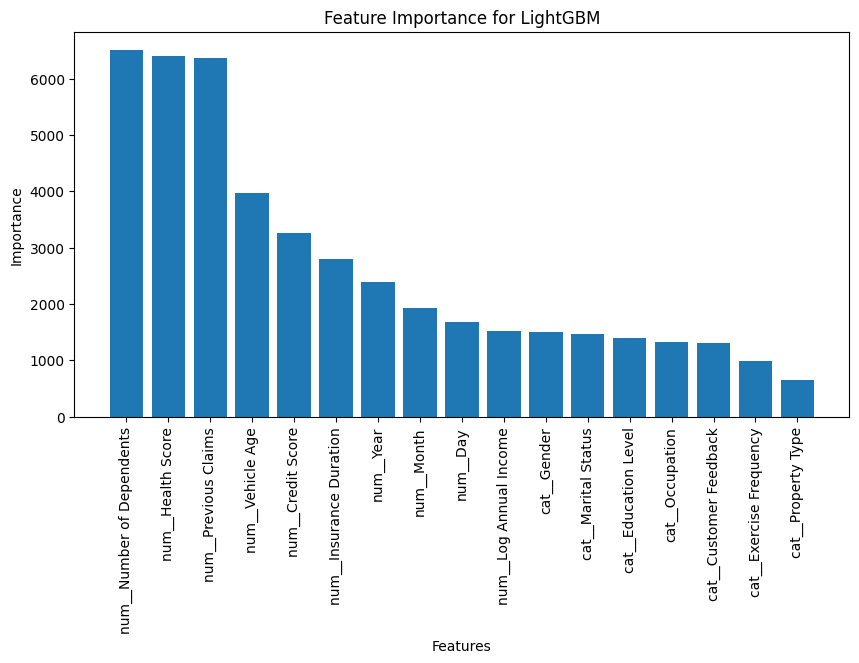

In [70]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True,random_state=42)

# Initialize model
lgb_params_2 = {
        'max_depth': 10, 
        'num_leaves': 58, 
        'learning_rate': 0.08579016254024871, 
        'feature_fraction': 0.734968274884088, 
        'bagging_fraction': 0.8428557428919629, 
        'bagging_freq': 3, 
        'reg_alpha': 3.1802796944775924, 
        'reg_lambda': 2.0434363964173574, 
        'n_estimators': 797,
        'verbosity':-1,
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse'
}

lgb_2 = LGBMRegressor(**lgb_params_2)
scores = []

# Loop through each fold
for i, (train_idx, val_idx) in enumerate(kf.split(X_train_selected)):
    print(f"------------ Working on Fold {i} ------------")
    
    X_train_split, X_valid_split = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
    y_train_split, y_valid_split = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Fit model
    lgb_2.fit(X_train_split,y_train_split,
              eval_set=[(X_valid_split, y_valid_split)])
    y_pred_lgb = lgb_2.predict(X_valid_split)
    score = rmsle(y_valid_split, y_pred_lgb)
    print(f"The oof RMSLE score is {score}")
    scores.append(score)

lgb_oof_score = np.mean(scores)  
lgb_std = np.std(scores)
print(f"The 5-fold average oof RMSLE score of the LightGBM model is {lgb_oof_score}")
print(f"The 5-fold std oof RMSLE score of the LightGBM model is {lgb_std}") 

feature_importances = lgb_2.feature_importances_
print(feature_importances)
# Sort feature importances and corresponding feature names
sorted_indices = feature_importances.argsort()[::-1]
sorted_features = X_train_selected.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]
plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_features)
plt.title(f"Feature Importance for LightGBM")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(range(len(X_train_selected.columns)), X_train_selected.columns, rotation=90)
plt.show()

In [ ]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True,random_state=42)

# Initialize model
lgb_params_3 = {
        'objective': 'regression_l2',
        'metric': 'rmse',
        'max_depth': 11,
        'num_leaves': 169, 
        'min_child_samples': 27,
        'min_child_weight': 13,
        'colsample_bytree': 0.4844468439076937,
        'reg_alpha': 0.08086875774692211, 
        'reg_lambda': 0.9676995833820066,
        'random_state': 42,
        'verbose': -1,
        'n_estimators': 5000,
        'learning_rate': 0.01
}

lgb_3 = LGBMRegressor(**lgb_params_3)
scores = []

# Loop through each fold
for i, (train_idx, val_idx) in enumerate(kf.split(X_train_selected)):
    print(f"------------ Working on Fold {i} ------------")
    
    X_train_split, X_valid_split = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
    y_train_split, y_valid_split = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Fit model
    lgb_3.fit(X_train_split,y_train_split,
              eval_set=[(X_valid_split, y_valid_split)])
    y_pred_lgb = lgb_3.predict(X_valid_split)
    score = rmsle(y_valid_split, y_pred_lgb)
    print(f"The oof RMSLE score is {score}")
    scores.append(score)

lgb_oof_score = np.mean(scores)  
lgb_std = np.std(scores)
print(f"The 5-fold average oof RMSLE score of the LightGBM model is {lgb_oof_score}")
print(f"The 5-fold std oof RMSLE score of the LightGBM model is {lgb_std}") 

------------ Working on Fold 0 ------------


In [ ]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True,random_state=42)

# Initialize model
lgb_params_4 = {
        'objective': 'regression_l2',
        'metric': 'rmse',
        'max_depth': 12,
        'num_leaves': 246,
        'min_child_samples': 10,
        'min_child_weight': 24,
        'colsample_bytree': 0.49704729723832064,
        'reg_alpha': 0.2791624804454722,
        'reg_lambda': 0.7306747260034717,
        'random_state': 42,
        'verbose': -1,
        'n_estimators': 5000,
        'learning_rate': 0.01
}

lgb_4 = LGBMRegressor(**lgb_params_4)
scores = []

# Loop through each fold
for i, (train_idx, val_idx) in enumerate(kf.split(X_train_selected)):
    print(f"------------ Working on Fold {i} ------------")
    
    X_train_split, X_valid_split = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
    y_train_split, y_valid_split = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Fit model
    lgb_4.fit(X_train_split,y_train_split,
              eval_set=[(X_valid_split, y_valid_split)])
    y_pred_lgb = lgb_4.predict(X_valid_split)
    score = rmsle(y_valid_split, y_pred_lgb)
    print(f"The oof RMSLE score is {score}")
    scores.append(score)

lgb_oof_score = np.mean(scores)  
lgb_std = np.std(scores)
print(f"The 5-fold average oof RMSLE score of the LightGBM model is {lgb_oof_score}")
print(f"The 5-fold std oof RMSLE score of the LightGBM model is {lgb_std}") 

In [ ]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True,random_state=42)

# Initialize model
lgb_params_5 = {
        'random_state': 42,
        'verbose': -1,
        'boosting_type': 'gbdt',
        'n_estimators': 3000,
        'eval_metric': 'rmse',
        'objective': 'regression_l2',
        'learning_rate': 0.01,
        'max_bin': 8000,
        'max_depth': 8, 
        'num_leaves': 796,
        'min_child_samples': 21,
        'min_child_weight': 11,
        'colsample_bytree': 0.48551477424501904, 
        'reg_alpha': 0.44307695050069845, 
        'reg_lambda': 0.9310703189038081
}

lgb_5 = LGBMRegressor(**lgb_params_5)
scores = []

# Loop through each fold
for i, (train_idx, val_idx) in enumerate(kf.split(X_train_selected)):
    print(f"------------ Working on Fold {i} ------------")
    
    X_train_split, X_valid_split = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
    y_train_split, y_valid_split = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Fit model
    lgb_5.fit(X_train_split,y_train_split,
              eval_set=[(X_valid_split, y_valid_split)])
    y_pred_lgb = lgb_5.predict(X_valid_split)
    score = rmsle(y_valid_split, y_pred_lgb)
    print(f"The oof RMSLE score is {score}")
    scores.append(score)

lgb_oof_score = np.mean(scores)  
lgb_std = np.std(scores)
print(f"The 5-fold average oof RMSLE score of the LightGBM model is {lgb_oof_score}")
print(f"The 5-fold std oof RMSLE score of the LightGBM model is {lgb_std}") 

### CatBoost

In [ ]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True,random_state=42)

# Initialize model
cat_params_1 = {
    'iterations': 971, 
    'depth': 9, 
    'learning_rate': 0.209173094311765, 
    'random_strength': 3.7025175269170347, 
    'bagging_temperature': 0.07181853264492258, 
    'border_count': 209, 
    'l2_leaf_reg': 31.926710123760373,         
    'eval_metric': 'RMSE',
    'random_state': 0,
    'verbose': 0}

cat_1 = CatBoostRegressor(**cat_params_1)
scores = []

# Loop through each fold
for i, (train_idx, val_idx) in enumerate(kf.split(X_train_selected)):
    print(f"------------ Working on Fold {i} ------------")
    
    X_train_split, X_valid_split = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
    y_train_split, y_valid_split = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Fit model
    cat_1.fit(X_train_split,y_train_split,
              eval_set=[(X_valid_split, y_valid_split)],
              early_stopping_rounds=50,
              cat_features=None,
              verbose=False)
    y_pred_cat = cat_1.predict(X_valid_split)
    score = rmsle(y_valid_split, y_pred_cat)
    print(f"The oof RMSLE score is {score}")
    scores.append(score)

cat_oof_score = np.mean(scores)  
cat_std = np.std(scores)

print(f"The 5-fold average oof RMSLE score of the CatBoost model is {cat_oof_score}")
print(f"The 5-fold std oof RMSLE score of the CatBoost model is {cat_std}") 

In [ ]:
feature_importances = cat_1.get_feature_importance()
print(feature_importances)
# Sort feature importances and corresponding feature names
sorted_indices = feature_importances.argsort()[::-1]
sorted_features = X_train_selected.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]
plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_features)
plt.title(f"Feature Importance for CatBoost")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(range(len(X_train_selected.columns)), X_train_selected.columns, rotation=90)
plt.show()

In [ ]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True,random_state=42)

# Initialize model
cat_params_2 = {
        'verbose': 0,
        'random_state': 42,
        'eval_metric': "RMSE",
        'objective': 'RMSE', 
        'depth': 13, 
        'subsample': 0.9998449533801151,
        'min_data_in_leaf': 63,
        'l2_leaf_reg': 0.3242106539167982,
        "iterations" : 1000,
        'learning_rate': 0.1
}

cat_2 = CatBoostRegressor(**cat_params_2)
scores = []

# Loop through each fold
for i, (train_idx, val_idx) in enumerate(kf.split(X_train_selected)):
    print(f"------------ Working on Fold {i} ------------")
    
    X_train_split, X_valid_split = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
    y_train_split, y_valid_split = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Fit model
    cat_2.fit(X_train_split,y_train_split,
              eval_set=[(X_valid_split, y_valid_split)],
              early_stopping_rounds=50,
              cat_features=None,
              verbose=False)
    y_pred_cat = cat_2.predict(X_valid_split)
    score = rmsle(y_valid_split, y_pred_cat)
    print(f"The oof RMSLE score is {score}")
    scores.append(score)

cat_oof_score = np.mean(scores)  
cat_std = np.std(scores)

print(f"The 5-fold average oof RMSLE score of the CatBoost model is {cat_oof_score}")
print(f"The 5-fold std oof RMSLE score of the CatBoost model is {cat_std}") 

In [ ]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True,random_state=42)

# Initialize model
cat_params_3 = {
        'objective': 'RMSE',
        'depth': 11,
        'subsample': 0.9581878706329088,
        'min_data_in_leaf': 43,
        'l2_leaf_reg': 0.08249502036269224,
        'verbose': 0,
        'random_state': 42,
        'eval_metric': "RMSE",
        "iterations" : 1000,
        'learning_rate': 0.05,
        'bootstrap_type': 'Bernoulli'
}

cat_3 = CatBoostRegressor(**cat_params_3)
scores = []

# Loop through each fold
for i, (train_idx, val_idx) in enumerate(kf.split(X_train_selected)):
    print(f"------------ Working on Fold {i} ------------")
    
    X_train_split, X_valid_split = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
    y_train_split, y_valid_split = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Fit model
    cat_3.fit(X_train_split,y_train_split,
              eval_set=[(X_valid_split, y_valid_split)],
              early_stopping_rounds=50,
              cat_features=None,
              verbose=False)
    y_pred_cat = cat_3.predict(X_valid_split)
    score = rmsle(y_valid_split, y_pred_cat)
    print(f"The oof RMSLE score is {score}")
    scores.append(score)

cat_oof_score = np.mean(scores)  
cat_std = np.std(scores)

print(f"The 5-fold average oof RMSLE score of the CatBoost model is {cat_oof_score}")
print(f"The 5-fold std oof RMSLE score of the CatBoost model is {cat_std}") 

In [ ]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True)

# Initialize model
cat_params_4 = {
        'objective': 'RMSE',
        'depth': 11, 
        'min_data_in_leaf': 51, 
        'l2_leaf_reg': 7.51216069323258,
        'random_state': 42,
        'early_stopping_rounds': 200,
        'eval_metric': "RMSE",
        "iterations" : 1000,
        'learning_rate': 0.01,
        'bootstrap_type': 'Bernoulli'
}

cat_4 = CatBoostRegressor(**cat_params_4)
scores = []

# Loop through each fold
for i, (train_idx, val_idx) in enumerate(kf.split(X_train_selected)):
    print(f"------------ Working on Fold {i} ------------")
    
    X_train_split, X_valid_split = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
    y_train_split, y_valid_split = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Fit model
    cat_4.fit(X_train_split,y_train_split,
              eval_set=[(X_valid_split, y_valid_split)],
              early_stopping_rounds=50,
              cat_features=None,
              verbose=False)
    y_pred_cat = cat_4.predict(X_valid_split)
    score = rmsle(y_valid_split, y_pred_cat)
    print(f"The oof RMSLE score is {score}")
    scores.append(score)

cat_oof_score = np.mean(scores)  
cat_std = np.std(scores)

print(f"The 5-fold average oof RMSLE score of the CatBoost model is {cat_oof_score}")
print(f"The 5-fold std oof RMSLE score of the CatBoost model is {cat_std}") 

In [ ]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True,random_state=42)

# Initialize model
cat_params_5 = {
        'objective': 'RMSE',
        'logging_level': 'Silent',
        'depth': 11,
        'min_data_in_leaf': 62,
        'l2_leaf_reg': 7.887761285633826,
        'random_state': 42,
        'eval_metric': "RMSE",
        "iterations" : 1000,
        'learning_rate': 0.01
}

cat_5 = CatBoostRegressor(**cat_params_5)
scores = []

# Loop through each fold
for i, (train_idx, val_idx) in enumerate(kf.split(X_train_selected)):
    print(f"------------ Working on Fold {i} ------------")
    
    X_train_split, X_valid_split = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
    y_train_split, y_valid_split = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Fit model
    cat_5.fit(X_train_split,y_train_split,
              eval_set=[(X_valid_split, y_valid_split)],
              early_stopping_rounds=50,
              cat_features=None,
              verbose=False)
    y_pred_cat = cat_5.predict(X_valid_split)
    score = rmsle(y_valid_split, y_pred_cat)
    print(f"The oof RMSLE score is {score}")
    scores.append(score)

cat_oof_score = np.mean(scores)  
cat_std = np.std(scores)

print(f"The 5-fold average oof RMSLE score of the CatBoost model is {cat_oof_score}")
print(f"The 5-fold std oof RMSLE score of the CatBoost model is {cat_std}") 

In [ ]:
# # Define Regressor class
# class Regressor:
#     def __init__(self, eval_metric):
#         self.eval_metric = eval_metric
#         self.models = self._initialize_models()

#     def _initialize_models(self):
#         # Define model parameters
#         xgb_params_1 = {
#             'max_depth': 7, 
#             'learning_rate': 0.08892164153650667, 
#             'min_child_weight': 1.000812173349267, 
#             'colsample_bytree': 0.6037524966913294, 
#             'reg_alpha': 1.587471515505295, 
#             'reg_lambda': 5.340290532777649, 
#             'subsample': 0.583899963777622, 
#             'n_estimators': 494,
#             'objective': 'reg:squaredlogerror',
#             'booster': 'gbtree',
#             'eval_metric': 'rmse',
#             'random_state': 0}
#         xgb_params_2 = {
#             'max_depth': 7, 
#             'learning_rate': 0.048600089743471644, 
#             'min_child_weight': 1.1685927782882253, 
#             'colsample_bytree': 0.5288242720975447, 
#             'reg_alpha': 8.062968886652984, 
#             'reg_lambda': 0.09005692004244192, 
#             'subsample': 0.9618549980615656, 
#             'n_estimators': 476,
#             'objective': 'reg:squaredlogerror',
#             'booster': 'gbtree',
#             'eval_metric': 'rmse',
#             'random_state': 0
#         }
#         lgb_params_1 = {
#             'max_depth': 10, 
#             'num_leaves': 58, 
#             'learning_rate': 0.08579016254024871, 
#             'feature_fraction': 0.734968274884088, 
#             'bagging_fraction': 0.8428557428919629, 
#             'bagging_freq': 3, 
#             'reg_alpha': 3.1802796944775924, 
#             'reg_lambda': 2.0434363964173574, 
#             'n_estimators': 797,
#             'boosting_type': 'gbdt',
#             'objective': 'regression',
#             'metric': 'rmse'
#         }
#         lgb_params_2 = {
#             'max_depth': 11, 
#             'num_leaves': 28, 
#             'learning_rate': 0.07647055187712827, 
#             'feature_fraction': 0.9845340232901648, 
#             'bagging_fraction': 0.9751777653062266, 
#             'bagging_freq': 4, 
#             'reg_alpha': 1.9794504987659611, 
#             'reg_lambda': 1.5074268152177714, 
#             'n_estimators': 904,
#             'boosting_type': 'gbdt',
#             'objective': 'regression',
#             'metric': 'rmse'}
#         cat_params_1 = {
#             'iterations': 971, 
#             'depth': 9, 
#             'learning_rate': 0.209173094311765, 
#             'random_strength': 3.7025175269170347, 
#             'bagging_temperature': 0.07181853264492258, 
#             'border_count': 209, 
#             'l2_leaf_reg': 31.926710123760373,         
#             'eval_metric': 'RMSE',
#             'random_state': 0,
#             'verbose': 0}
#         # Define models
#         return {
#             'xgb_1': XGBRegressor(**xgb_params_1),
#             'xgb_2': XGBRegressor(**xgb_params_2),
#             'lgb_1': LGBMRegressor(**lgb_params_1),
#             'lgb_2': LGBMRegressor(**lgb_params_2),
#             'cat_1': CatBoostRegressor(**cat_params_1)
#         }
#     # Fit model with cross-validation
#     def fit(self, X, y):
#         results = []
#         # Split the data
#         X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(X, y, test_size=0.2, random_state=42)
        
#         for name, model in self.models.items():
#             if ('xgb' in name) or ('lgb' in name) or ('cat' in name):
#                 if 'lgb' in name:
#                     model.fit(X_train_split, y_train_split, eval_set=[(X_valid_split, y_valid_split)])
#                 elif 'cat' in name:
#                     model.fit(
#                         X_train_split, y_train_split, 
#                         eval_set=[(X_valid_split, y_valid_split)],
#                         early_stopping_rounds=50,
#                         cat_features=None,
#                         verbose=False
#                     )  
#                 else:
#                     model.fit(
#                         X_train_split, y_train_split, 
#                         eval_set=[(X_valid_split, y_valid_split)],
#                         early_stopping_rounds=50,
#                         verbose=False
#                     )
            
#             # Predict and calculate metric
#             y_pred = model.predict(X_valid_split)
#             metric_value = self.eval_metric(y_valid_split, y_pred)
            
#             # Save the result
#             results.append({
#                 "Model": name,
#                 "Metric": metric_value,
#                 "Predictions": y_pred
#             })
            
#             # Plot feature importance if available
#             self._plot_feature_importance(name, model, X)
#         return results
        
#     def _plot_feature_importance(self, name, model, X):
#         # Check if model supports feature importance
#         if hasattr(model, 'feature_importances_'):
#             feature_importances = model.feature_importances_
#             print(feature_importances)
#             # Sort feature importances and corresponding feature names
#             sorted_indices = feature_importances.argsort()[::-1]
#             sorted_features = X.columns[sorted_indices]
#             sorted_importances = feature_importances[sorted_indices]
#             plt.figure(figsize=(10, 5))
#             plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_features)
#             plt.title(f"Feature Importance for {name}")
#             plt.xlabel("Features")
#             plt.ylabel("Importance")
#             plt.xticks(range(len(X.columns)), X.columns, rotation=90)
#             plt.show()
#         elif hasattr(model, 'get_feature_importance'):  # For CatBoost
#             feature_importances = model.get_feature_importance()
#             print(feature_importances)
#             # Sort feature importances and corresponding feature names
#             sorted_indices = feature_importances.argsort()[::-1]
#             sorted_features = X.columns[sorted_indices]
#             sorted_importances = feature_importances[sorted_indices]
#             plt.figure(figsize=(10, 5))
#             plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_features)
#             plt.title(f"Feature Importance for {name}")
#             plt.xlabel("Features")
#             plt.ylabel("Importance")
#             plt.xticks(range(len(X.columns)), X.columns, rotation=90)
#             plt.show()
#         else:
#             print(f"{name} does not support feature importance.")
    
#     # Predict and evaluate on valid split
#     def validate(self, X, y):
#         validations = []
#         for name, model in self.models.items():
#             # Predict and calculate metric
#             y_pred = model.predict(X)
#             metric_value = self.eval_metric(y, y_pred)

#             # Save the result
#             validations.append({
#                 "Model": name,
#                 "Metric": metric_value,
#                 "Predictions": y_pred
#             })
#             # feature importance
#             print(model.feature_importances_)
#             # plot
#             pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
#             pyplot.show()
#         return validations

In [ ]:
# # Initialize evaluator
# model = Regressor(eval_metric=rmsle)

# # Fit and evaluate models
# results = model.fit(X_train_processed, y_train)

# # Display results
# for result in results:
#     print(f"Model: {result['Model']}, RMSLE: {result['Metric']}")

## LightAutoML

In [ ]:
# def map_class(x, task, reader):
#     if task.name == 'multiclass':
#         return reader[x]
#     else:
#         return x

# mapped = np.vectorize(map_class)

# def score(task, y_true, y_pred):
#     if task.name == 'binary':
#         return roc_auc_score(y_true, y_pred)
#     elif task.name == 'multiclass':
#         return accuracy_score(y_true, np.argmax(y_pred, 1))
#     elif task.name == 'reg' or task.name == 'multi:reg':
#         return median_absolute_error(y_true, y_pred)
#     else:
#         raise 'Task is not correct.'
        
# def take_pred_from_task(pred, task):
#     if task.name == 'binary' or task.name == 'reg':
#         return pred[:, 0]
#     elif task.name == 'multiclass' or task.name == 'multi:reg':
#         return pred
#     else:
#         raise 'Task is not correct.'
        
# def use_plr(USE_PLR):
#     if USE_PLR:
#         return "plr"
#     else:
#         return "cont"

In [ ]:
# RANDOM_STATE = 42
# N_THREADS = os.cpu_count()
# TIMEOUT = 9 * 3600
# N_FOLDS = 10
# np.random.seed(RANDOM_STATE)
# torch.set_num_threads(N_THREADS)

In [ ]:
# task = Task('reg') 
# automl = TabularAutoML(
#     task = task, 
#     timeout = 9 * 3600,
#     cpu_limit = os.cpu_count(),
#     nn_params = {
#     'stop_by_metric': True,
#     'verbose_bar': True},
#     nn_pipeline_params = {"use_qnt": False, "use_te": False},
#     reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE, 'advanced_roles': True}
# )

In [ ]:
# task = Task('reg') 
# automl = TabularAutoML(
#     task = task,
#     timeout = TIMEOUT,
#     cpu_limit = N_THREADS,
#     general_params = {"use_algos": [["nn"]]}, # ['nn', 'mlp', 'dense', 'denselight', 'resnet', 'snn', 'node', 'autoint', 'fttransformer'] or custom torch model
#     nn_params = {"n_epochs": 10, "bs": 512, "num_workers": 0, "path_to_save": None, "freeze_defaults": True},
#     nn_pipeline_params = {"use_qnt": True, "use_te": False},
#     reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
# )

In [ ]:
# out_of_fold_predictions = automl.fit_predict(
#     df_train_automl,
#     roles = {
#         'target': 'Premium Amount',
#         'drop': 'id'
#     }, 
#     verbose = 3
# )

# Evaluate

In [ ]:
# # Validate LightAutoML model
# rmsle(out_of_fold_predictions.data[:, 0], df_train_automl['Premium Amount'])

In [ ]:
y_preds = {}

y_preds['xgb_1'] = xgb_1.predict(X_valid_selected)
y_preds['xgb_2'] = xgb_2.predict(X_valid_selected)
y_preds['xgb_3'] = xgb_3.predict(X_valid_selected)
y_preds['xgb_4'] = xgb_4.predict(X_valid_selected)
y_preds['xgb_5'] = xgb_5.predict(X_valid_selected)

y_preds['lgb_1'] = lgb_1.predict(X_valid_selected)
y_preds['lgb_2'] = lgb_2.predict(X_valid_selected)
y_preds['lgb_3'] = lgb_3.predict(X_valid_selected)
y_preds['lgb_4'] = lgb_4.predict(X_valid_selected)
y_preds['lgb_5'] = lgb_5.predict(X_valid_selected)

y_preds['cat_1'] = cat_1.predict(X_valid_selected)
y_preds['cat_2'] = cat_2.predict(X_valid_selected)
y_preds['cat_3'] = cat_3.predict(X_valid_selected)
y_preds['cat_4'] = cat_4.predict(X_valid_selected)
y_preds['cat_5'] = cat_5.predict(X_valid_selected)

In [ ]:
rmsle = {}

rmsle['xgb_1'] = mean_squared_log_error(y_valid, y_preds['xgb_1'])
rmsle['xgb_2'] = mean_squared_log_error(y_valid, y_preds['xgb_2'])
rmsle['xgb_3'] = mean_squared_log_error(y_valid, y_preds['xgb_3'])
rmsle['xgb_4'] = mean_squared_log_error(y_valid, y_preds['xgb_4'])
rmsle['xgb_5'] = mean_squared_log_error(y_valid, y_preds['xgb_5'])

rmsle['lgb_1'] = mean_squared_log_error(y_valid, y_preds['lgb_1'])
rmsle['lgb_2'] = mean_squared_log_error(y_valid, y_preds['lgb_2'])
rmsle['lgb_3'] = mean_squared_log_error(y_valid, y_preds['lgb_3'])
rmsle['lgb_4'] = mean_squared_log_error(y_valid, y_preds['lgb_4'])
rmsle['lgb_5'] = mean_squared_log_error(y_valid, y_preds['lgb_5'])

rmsle['cat_1'] = mean_squared_log_error(y_valid, y_preds['cat_1'])
rmsle['cat_2'] = mean_squared_log_error(y_valid, y_preds['cat_2'])
rmsle['cat_3'] = mean_squared_log_error(y_valid, y_preds['cat_3'])
rmsle['cat_4'] = mean_squared_log_error(y_valid, y_preds['cat_4'])
rmsle['cat_5'] = mean_squared_log_error(y_valid, y_preds['cat_5'])

for model, score in rmsle.items():
    print(f"The RMSLE score of the {model} is {score}")

In [ ]:
# Sort the dictionary by keys
sorted_rmsle = dict(sorted(rmsle.items()))

# Create lists of keys and values for plotting
models = list(sorted_rmsle.keys())
scores = list(sorted_rmsle.values())

# Create a bar chart
plt.figure(figsize=(10,6))
hbars = plt.bar(models, scores, width = 0.7)
plt.bar_label(hbars, fmt='%.4f')
plt.xlabel('Models')
plt.ylabel('RMSLE')
plt.title('Model Evaluation')          
plt.show()

# Ensemble

## Stacking 

In [ ]:
# from sklearn.ensemble import StackingRegressor
# from sklearn.ensemble import HistGradientBoostingRegressor
# meta_model = HistGradientBoostingRegressor(max_depth = 3)

# base_models = [
#     ('xgb_1', xgb_1),
#     ('lgb_1', lgb_1),
#     ('cat_1', cat_1)
# ]

# stacking_regressor = StackingRegressor(
#     estimators=base_models,
#     final_estimator=meta_model,
#     cv=5 
# )
# stacking_regressor.fit(X_train_selected, y_train)

In [ ]:
# scores = cross_val_score(stacking_regressor, X_train_selected, y_train, cv=5, scoring=RMSLE)

# print("Cross-Validation RMSLE:", -scores.mean())

# y_pred_stack = stacking_regressor.predict(X_valid_selected)

# # Evaluate final ensemble
# stack_rmsle = rmsle(y_valid, y_pred_stack)
# print(f"Stacking Ensemble RMSLE: {stack_rmsle}")

## Blending

In [ ]:
w_xgb_1 = 0.1
w_xgb_2 = 0.1
w_xgb_3 = 0.1
w_xgb_4 = 0.1
w_xgb_5 = 0.1

w_lgb_1 = 0.06
w_lgb_2 = 0.06
w_lgb_3 = 0.06
w_lgb_4 = 0.06
w_lgb_5 = 0.06

w_cat_1 = 0.04
w_cat_2 = 0.04
w_cat_3 = 0.04
w_cat_4 = 0.04
w_cat_5 = 0.04

y_pred_ensemble = (
    w_xgb_1 * y_preds['xgb_1'] +
    w_xgb_2 * y_preds['xgb_2'] +
    w_xgb_3 * y_preds['xgb_3'] +
    w_xgb_4 * y_preds['xgb_4'] +
    w_xgb_5 * y_preds['xgb_5'] +
    w_lgb_1 * y_preds['lgb_1'] +
    w_lgb_2 * y_preds['lgb_2'] +
    w_lgb_3 * y_preds['lgb_3'] +
    w_lgb_4 * y_preds['lgb_4'] +
    w_lgb_5 * y_preds['lgb_5'] +
    w_cat_1 * y_preds['cat_1'] +
    w_cat_2 * y_preds['cat_2'] +
    w_cat_3 * y_preds['cat_3'] +
    w_cat_4 * y_preds['cat_4'] +
    w_cat_5 * y_preds['cat_5']
)

# Calculate RMSLE for the ensemble
blend_rmsle = rmsle(y_valid, y_pred_ensemble)
# blend_rmsle = rmsle(y_valid, np.expm1(y_pred_ensemble))
print(f"Blending Ensemble RMSLE: {blend_rmsle}")

# Submission

In [ ]:
X = extract_date_components(X, 'Policy Start Date')
X_processed = preprocessor.fit_transform(X, y_log)
X_selected = X_processed.drop(columns = lower_cv_features)

In [ ]:
df_test_processed = preprocessor.transform(df_test)
df_test_selected = df_test_processed.drop(columns = lower_cv_features)

In [ ]:
# if stack_rmsle < blend_rmsle:
#     # Stacking
#     y_pred_test_ensemble = stacking_regressor.predict(df_test_selected)
# else:
#     # Blending
test_preds = {}
test_preds['xgb_1'] = xgb_1.fit(X_selected, y_log).predict(df_test_selected)
test_preds['xgb_2'] = xgb_2.fit(X_selected, y_log).predict(df_test_selected)
test_preds['xgb_3'] = xgb_3.fit(X_selected, y_log).predict(df_test_selected)
test_preds['xgb_4'] = xgb_4.fit(X_selected, y_log).predict(df_test_selected)
test_preds['xgb_5'] = xgb_5.fit(X_selected, y_log).predict(df_test_selected)

test_preds['lgb_1'] = lgb_1.fit(X_selected, y_log).predict(df_test_selected)
test_preds['lgb_2'] = lgb_2.fit(X_selected, y_log).predict(df_test_selected)
test_preds['lgb_3'] = lgb_3.fit(X_selected, y_log).predict(df_test_selected)
test_preds['lgb_4'] = lgb_4.fit(X_selected, y_log).predict(df_test_selected)
test_preds['lgb_5'] = lgb_5.fit(X_selected, y_log).predict(df_test_selected)

test_preds['cat_1'] = cat_1.fit(X_selected, y_log).predict(df_test_selected)
test_preds['cat_2'] = cat_2.fit(X_selected, y_log).predict(df_test_selected)
test_preds['cat_3'] = cat_3.fit(X_selected, y_log).predict(df_test_selected)
test_preds['cat_4'] = cat_4.fit(X_selected, y_log).predict(df_test_selected)
test_preds['cat_5'] = cat_5.fit(X_selected, y_log).predict(df_test_selected)

# Combine predictions with weights
y_log_pred_test_ensemble = (
    w_xgb_1 * test_preds['xgb_1'] +
    w_xgb_2 * test_preds['xgb_2'] +
    w_xgb_3 * test_preds['xgb_3'] +
    w_xgb_4 * test_preds['xgb_4'] +
    w_xgb_5 * test_preds['xgb_5'] +
    w_lgb_1 * test_preds['lgb_1'] +
    w_lgb_2 * test_preds['lgb_2'] +
    w_lgb_3 * test_preds['lgb_3'] +
    w_lgb_4 * test_preds['lgb_4'] +
    w_lgb_5 * test_preds['lgb_5'] +
    w_cat_1 * test_preds['cat_1'] +
    w_cat_2 * test_preds['cat_2'] +
    w_cat_3 * test_preds['cat_3'] +
    w_cat_4 * test_preds['cat_4'] +
    w_cat_5 * test_preds['cat_5']
)

# Transform back to the original scale
y_pred_test_ensemble = np.expm1(y_log_pred_test_ensemble)

In [ ]:
# Create submission file
df_sub = pd.read_csv('/kaggle/input/playground-series-s4e12/sample_submission.csv')
df_sub['Premium Amount'] = y_pred_test_ensemble
df_sub.to_csv('submission_ensemble.csv', index=False)
df_sub.head()

# Appendix

## XGB Optuna

In [ ]:
# def objective(trial):
#     # Define hyperparameter search space
#     params = {
#         'booster': 'gbtree',
#         'objective': 'reg:squaredlogerror',  # For RMSLE
#         'eval_metric': 'rmse',              # Metric for evaluation
#         'max_depth': trial.suggest_int('max_depth', 3, 20),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
#         'min_child_weight': trial.suggest_float('min_child_weight', 1, 15),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'device': 'cuda',  # Use GPU if available
#         'random_state': 0
#     }

#     # Split data for validation
#     X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
#         X_train_processed, y_train, test_size=0.2, random_state=42)

#     # Train XGBoost model
#     model = XGBRegressor(**params)
#     model.fit(
#         X_train_split, y_train_split,
#         eval_set=[(X_valid_split, y_valid_split)],
#         early_stopping_rounds=50,
#         verbose=False
#     )

#     # Predict on validation data
#     y_pred = model.predict(X_valid_split)

#     # Calculate RMSLE
#     rmsle_score = rmsle(y_valid_split, y_pred)
#     return rmsle_score

In [ ]:
# study = optuna.create_study(direction='minimize')  # Minimize RMSLE
# study.optimize(objective, n_trials=50)

# # Get the best parameters
# xgb_best_params = study.best_params
# print("Best Parameters:", xgb_best_params)

In [ ]:
# # Split the training data to include a validation set for early stopping
# X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# # Create the XGBoost model using Optuna model
# xgb_best_params_1 = {'max_depth': 4, 
#                     'learning_rate': 0.028949993238818562, 
#                     'min_child_weight': 7.472178342152908, 
#                     'colsample_bytree': 0.5048225534122298, 
#                     'reg_alpha': 8.993064644792046, 
#                     'reg_lambda': 3.4598638747943316, 
#                     'subsample': 0.5687531348526244, 
#                     'n_estimators': 750,
#                     'objective': 'reg:squaredlogerror',
#                     'booster': 'gbtree',
#                     'eval_metric': 'rmse',
#                     'device': 'cuda',
#                     'random_state': 0}

# xgb_1 = XGBRegressor(**xgb_best_params)

# # Fit the model with early stopping
# xgb_1.fit(X_train_split, y_train_split,
#           eval_set=[(X_valid_split, y_valid_split)],
#           early_stopping_rounds=50,
#           verbose=500)

# # Predict probabilities on validation data
# y_pred_xgb_1 = xgb_1.predict(X_valid)

# # Calculate Accuracy Score on validation data
# xgb_rmsle = rmsle(y_valid, y_pred_xgb_1)
# print("RMSLE on Validation Data:", xgb_rmsle)

## LGBM Optuna

In [ ]:
# # Define RMSLE evaluation metric
# def rmsle(y_true, y_pred):
#     return np.sqrt(np.mean((np.log1p(y_true) - np.log1p(y_pred)) ** 2))

# # Define the objective function
# def objective(trial):
#     # Define the hyperparameter search space
#     params = {
#         'boosting_type': 'gbdt',
#         'objective': 'regression',
#         'metric': 'rmse',
#         'max_depth': trial.suggest_int('max_depth', 3, 12),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 150),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
#         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'random_state': 0,
#         'verbose': -1
#     }

#     # Split data into training and validation sets
#     X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
#         X_train_processed, y_train, test_size=0.2, random_state=42
#     )

#     # Train LightGBM model
#     model = LGBMRegressor(**params)
#     model.fit(X_train_split, y_train_split)

#     # Predict on validation data
#     y_pred = model.predict(X_valid_split)

#     # Calculate RMSLE
#     return rmsle(y_valid_split, y_pred)

In [ ]:
# # Create an Optuna study to minimize RMSLE
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)

# # Get and print the best parameters
# lgb_best_params = study.best_params
# print("Best Parameters:", lgb_best_params)

## CatBoost Optuna

In [ ]:
# def objective(trial):
#     # Define hyperparameter search space
#     params = {
#         'iterations': trial.suggest_int('iterations', 100, 1000),
#         'depth': trial.suggest_int('depth', 4, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'random_strength': trial.suggest_float('random_strength', 0.1, 10.0),
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
#         'border_count': trial.suggest_int('border_count', 1, 255),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 100),
#         'eval_metric': 'RMSE',
#         'random_state': 0,
#         'verbose': 0
#     }

#     # Split the training data into training and validation sets
#     X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(X_train_processed, y_train, test_size=0.2, random_state=0)

#     # Train CatBoost model with current hyperparameters
#     model = CatBoostRegressor(**params)
#     model.fit(X_train_split, y_train_split, eval_set=(X_valid_split, y_valid_split), early_stopping_rounds=50)

#     # Predict on validation set
#     y_pred = model.predict(X_valid_split)

#     # Calculate RMSLE
#     rmsle_score = rmsle(y_valid_split, y_pred)
#     return rmsle_score

In [ ]:
# # Optimize hyperparameters using Optuna
# study = optuna.create_study(direction='minimize')  # Minimize RMSLE
# study.optimize(objective, n_trials=50)

# # Get best hyperparameters
# cat_best_params = study.best_params
# print("Best Hyperparameters:", cat_best_params)